# CAP 5771 - Principles of Data Mining 
Haibin Guan 

P.ID 6039501

Email: hguna003@fiu.edu

Homwork 7

#### Classify  NotMNIST Dataset using Convolutional Neural Network with Pytorch

In [214]:
# Import requiured libraries
import os
import glob
import numpy as np
import PIL
from skimage import io, transform
from skimage.io import imread
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [215]:
## Define a dataloader function for notMNIST dataset
class not_mnist(Dataset):
    def __init__(self, filedir):
        Images= []
        Labels=[]
        for folder in os.listdir(filedir):
            folder_path = os.path.join(filedir, folder)
            for im in os.listdir(folder_path):
                try:
                    img_path = os.path.join(folder_path, im)
                    Images.append(np.array(imread(img_path)))
                    Labels.append(ord(folder) - 65)  
                except:
                    pass
        sample = [(x, y) for x, y in zip(Images, Labels)]
        self.sample = sample

    def __len__(self):
        return len(self.sample)

    def __getitem__(self, idx):
        img = self.sample[idx][0]
        img = img.reshape(1, 28, 28)
        img = transforms.ToTensor()(img).view(1, 28, 28).float()
        img = transforms.Normalize(mean=(0.5,),std=(0.5,))(img)
        label = self.sample[idx][1]
        return (img, label)

#### Explore the data

In [216]:
## Use 'notMNIST_large' as data set 
data_set=not_mnist('notMNIST_large')
num_data = len(data_set)
indices = list(range(num_data))
##split set into train set and validation set
train_size = int(0.7 * len(data_set))
valid_size = len(data_set) - train_size
train_set, valid_set = torch.utils.data.random_split(data_set, [train_size, valid_size])
print('Number of images in the whole data set: {0}'.format(num_data))
print('Number of images in the training set: {0}'.format(train_size))
print('Number of images in the validation set: {0}'.format(valid_size))

Number of images in the whole data set: 529114
Number of images in the training set: 370379
Number of images in the validation set: 158735


##### Visualize some images

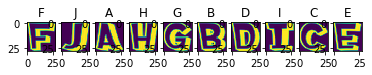

In [231]:
## View the  data set
filedir='notMNIST_large'
folders = os.listdir(filedir)
for folder in folders:
    idx=folders.index(folder)+1
    folder_path = os.path.join(filedir, folder)
    for im in os.listdir(folder_path)[200:201]:
        img_path = os.path.join(folder_path, im)
        img=np.array(imread(img_path))
        plt.subplot(1,10,idx)
        plt.imshow(img)
        plt.title(folder)                  

##### Load the data into Tensors

In [218]:
## Data Loader with different batch_size
train_loader= data_utils.DataLoader(train_set, batch_size=32, shuffle = True)
validation_loader= data_utils.DataLoader(valid_set, batch_size=128, shuffle = True)

In [219]:
class notMnistNet(torch.nn.Module):
    def __init__(self):
        ## Network Structure
        super(notMnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(5,5))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, 10)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3,3))
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3,3))
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(1,1))
        self.bn6 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_drop(F.max_pool2d(self.bn2(x),2))
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.max_pool2d(x,2)
        x = self.conv2_drop(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = F.relu(self.conv6(x))
        x = self.bn6(x)
        size =  x.size()[1]*x.size()[2]*x.size()[3]
        #print(size)
        x = x.view(-1, size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Training and Evaluation the network

In [232]:
# move the model to cuda 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = notMnistNet()ç
## Construct an optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.05)
criterion = nn.CrossEntropyLoss()

train_accu_list=[]
train_loss_list=[]
test_accu_list=[]
test_loss_list=[]
iter_list=[]
iter=0
epochs=40
for epoch in range(epochs):
    # training phase
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        # move the variable to cuda
        x, target = x.to(device), target.to(device)
        # clear out the gradients accumulated for the parameters of the network
        optimizer.zero_grad()
        out = model(x)
        # compute the loss function
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
        correct_cnt+= (pred_label == target).sum().item()
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        # back-prop all the layers
        loss.backward()
        # update the parameters
        optimizer.step()
        iter+=1
        if (batch_idx+1) % 1000 == 0 or (batch_idx+1) == len(train_loader):
            print('epoch: [{}/{}], batch index: {}, train loss: {:.4f}, acc: {:.3f}'.format(
                epoch+1,epochs, batch_idx+1, ave_loss, correct_cnt*1.0/total_cnt))
            train_accu_list.append(correct_cnt*1.0/total_cnt)
            train_loss_list.append(ave_loss)
            iter_list.append(iter)
    # testing phase
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(validation_loader):
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
#         print(target.data)
        correct_cnt += (pred_label == target).sum().item()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        
        if (batch_idx+1) % 110 == 0 or (batch_idx+1) == len(test_loader):
            print('epoch: [{}/{}], batch index: {}, test loss: {:.4f}, acc: {:.3f}'.format(
                epoch+1, epochs, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt))
            test_accu_list.append(correct_cnt*1.0/total_cnt)
            test_loss_list.append(ave_loss)
    

# Save the trained model
torch.save(model.state_dict(),'./not_mnist_cnn.ckpt')

epoch: [1/40], batch index: 1000, train loss: 0.6614, acc: 0.787
epoch: [1/40], batch index: 2000, train loss: 0.4703, acc: 0.820
epoch: [1/40], batch index: 3000, train loss: 0.3885, acc: 0.835
epoch: [1/40], batch index: 4000, train loss: 0.3534, acc: 0.844
epoch: [1/40], batch index: 5000, train loss: 0.4141, acc: 0.851
epoch: [1/40], batch index: 6000, train loss: 0.4659, acc: 0.856
epoch: [1/40], batch index: 7000, train loss: 0.3637, acc: 0.860
epoch: [1/40], batch index: 8000, train loss: 0.3217, acc: 0.863
epoch: [1/40], batch index: 9000, train loss: 0.3433, acc: 0.866
epoch: [1/40], batch index: 10000, train loss: 0.3504, acc: 0.869
epoch: [1/40], batch index: 11000, train loss: 0.3581, acc: 0.871
epoch: [1/40], batch index: 11575, train loss: 0.2931, acc: 0.872
epoch: [1/40], batch index: 110, test loss: 0.3133, acc: 0.900
epoch: [1/40], batch index: 220, test loss: 0.3479, acc: 0.899
epoch: [1/40], batch index: 293, test loss: 0.3104, acc: 0.899
epoch: [1/40], batch index: 

epoch: [6/40], batch index: 9000, train loss: 0.2434, acc: 0.918
epoch: [6/40], batch index: 10000, train loss: 0.2702, acc: 0.918
epoch: [6/40], batch index: 11000, train loss: 0.2329, acc: 0.918
epoch: [6/40], batch index: 11575, train loss: 0.2774, acc: 0.918
epoch: [6/40], batch index: 110, test loss: 0.2729, acc: 0.921
epoch: [6/40], batch index: 220, test loss: 0.2630, acc: 0.919
epoch: [6/40], batch index: 293, test loss: 0.2822, acc: 0.919
epoch: [6/40], batch index: 330, test loss: 0.2686, acc: 0.919
epoch: [6/40], batch index: 440, test loss: 0.2720, acc: 0.918
epoch: [6/40], batch index: 550, test loss: 0.2580, acc: 0.918
epoch: [6/40], batch index: 660, test loss: 0.2800, acc: 0.918
epoch: [6/40], batch index: 770, test loss: 0.2702, acc: 0.918
epoch: [6/40], batch index: 880, test loss: 0.2840, acc: 0.918
epoch: [6/40], batch index: 990, test loss: 0.2577, acc: 0.918
epoch: [6/40], batch index: 1100, test loss: 0.2736, acc: 0.918
epoch: [6/40], batch index: 1210, test loss

epoch: [11/40], batch index: 330, test loss: 0.2523, acc: 0.923
epoch: [11/40], batch index: 440, test loss: 0.2686, acc: 0.922
epoch: [11/40], batch index: 550, test loss: 0.2482, acc: 0.922
epoch: [11/40], batch index: 660, test loss: 0.2501, acc: 0.922
epoch: [11/40], batch index: 770, test loss: 0.2364, acc: 0.922
epoch: [11/40], batch index: 880, test loss: 0.2529, acc: 0.922
epoch: [11/40], batch index: 990, test loss: 0.2604, acc: 0.922
epoch: [11/40], batch index: 1100, test loss: 0.2559, acc: 0.922
epoch: [11/40], batch index: 1210, test loss: 0.2930, acc: 0.922
epoch: [12/40], batch index: 1000, train loss: 0.2738, acc: 0.930
epoch: [12/40], batch index: 2000, train loss: 0.2402, acc: 0.928
epoch: [12/40], batch index: 3000, train loss: 0.2512, acc: 0.929
epoch: [12/40], batch index: 4000, train loss: 0.2450, acc: 0.928
epoch: [12/40], batch index: 5000, train loss: 0.2020, acc: 0.928
epoch: [12/40], batch index: 6000, train loss: 0.2201, acc: 0.927
epoch: [12/40], batch inde

epoch: [16/40], batch index: 990, test loss: 0.2383, acc: 0.924
epoch: [16/40], batch index: 1100, test loss: 0.2539, acc: 0.924
epoch: [16/40], batch index: 1210, test loss: 0.2347, acc: 0.924
epoch: [17/40], batch index: 1000, train loss: 0.2848, acc: 0.930
epoch: [17/40], batch index: 2000, train loss: 0.2028, acc: 0.930
epoch: [17/40], batch index: 3000, train loss: 0.2121, acc: 0.930
epoch: [17/40], batch index: 4000, train loss: 0.1745, acc: 0.930
epoch: [17/40], batch index: 5000, train loss: 0.2444, acc: 0.930
epoch: [17/40], batch index: 6000, train loss: 0.2333, acc: 0.931
epoch: [17/40], batch index: 7000, train loss: 0.2485, acc: 0.931
epoch: [17/40], batch index: 8000, train loss: 0.2084, acc: 0.931
epoch: [17/40], batch index: 9000, train loss: 0.2276, acc: 0.931
epoch: [17/40], batch index: 10000, train loss: 0.2361, acc: 0.931
epoch: [17/40], batch index: 11000, train loss: 0.2164, acc: 0.931
epoch: [17/40], batch index: 11575, train loss: 0.2395, acc: 0.931
epoch: [17/

epoch: [22/40], batch index: 4000, train loss: 0.1887, acc: 0.934
epoch: [22/40], batch index: 5000, train loss: 0.1859, acc: 0.934
epoch: [22/40], batch index: 6000, train loss: 0.1978, acc: 0.934
epoch: [22/40], batch index: 7000, train loss: 0.2196, acc: 0.934
epoch: [22/40], batch index: 8000, train loss: 0.2346, acc: 0.933
epoch: [22/40], batch index: 9000, train loss: 0.2290, acc: 0.933
epoch: [22/40], batch index: 10000, train loss: 0.1877, acc: 0.933
epoch: [22/40], batch index: 11000, train loss: 0.1926, acc: 0.933
epoch: [22/40], batch index: 11575, train loss: 0.2258, acc: 0.933
epoch: [22/40], batch index: 110, test loss: 0.2258, acc: 0.924
epoch: [22/40], batch index: 220, test loss: 0.2462, acc: 0.925
epoch: [22/40], batch index: 293, test loss: 0.2218, acc: 0.925
epoch: [22/40], batch index: 330, test loss: 0.2339, acc: 0.925
epoch: [22/40], batch index: 440, test loss: 0.2264, acc: 0.926
epoch: [22/40], batch index: 550, test loss: 0.2299, acc: 0.926
epoch: [22/40], bat

epoch: [27/40], batch index: 10000, train loss: 0.1933, acc: 0.936
epoch: [27/40], batch index: 11000, train loss: 0.1972, acc: 0.935
epoch: [27/40], batch index: 11575, train loss: 0.1763, acc: 0.936
epoch: [27/40], batch index: 110, test loss: 0.2573, acc: 0.924
epoch: [27/40], batch index: 220, test loss: 0.2477, acc: 0.926
epoch: [27/40], batch index: 293, test loss: 0.2488, acc: 0.926
epoch: [27/40], batch index: 330, test loss: 0.2310, acc: 0.926
epoch: [27/40], batch index: 440, test loss: 0.2557, acc: 0.925
epoch: [27/40], batch index: 550, test loss: 0.2420, acc: 0.926
epoch: [27/40], batch index: 660, test loss: 0.2627, acc: 0.926
epoch: [27/40], batch index: 770, test loss: 0.2437, acc: 0.926
epoch: [27/40], batch index: 880, test loss: 0.2345, acc: 0.926
epoch: [27/40], batch index: 990, test loss: 0.2589, acc: 0.926
epoch: [27/40], batch index: 1100, test loss: 0.2425, acc: 0.927
epoch: [27/40], batch index: 1210, test loss: 0.2335, acc: 0.926
epoch: [28/40], batch index: 

epoch: [32/40], batch index: 330, test loss: 0.2145, acc: 0.930
epoch: [32/40], batch index: 440, test loss: 0.2565, acc: 0.928
epoch: [32/40], batch index: 550, test loss: 0.2729, acc: 0.927
epoch: [32/40], batch index: 660, test loss: 0.2446, acc: 0.927
epoch: [32/40], batch index: 770, test loss: 0.2666, acc: 0.927
epoch: [32/40], batch index: 880, test loss: 0.2308, acc: 0.927
epoch: [32/40], batch index: 990, test loss: 0.2327, acc: 0.927
epoch: [32/40], batch index: 1100, test loss: 0.2255, acc: 0.927
epoch: [32/40], batch index: 1210, test loss: 0.2185, acc: 0.928
epoch: [33/40], batch index: 1000, train loss: 0.1592, acc: 0.940
epoch: [33/40], batch index: 2000, train loss: 0.1789, acc: 0.939
epoch: [33/40], batch index: 3000, train loss: 0.2490, acc: 0.939
epoch: [33/40], batch index: 4000, train loss: 0.2257, acc: 0.939
epoch: [33/40], batch index: 5000, train loss: 0.1817, acc: 0.938
epoch: [33/40], batch index: 6000, train loss: 0.2338, acc: 0.938
epoch: [33/40], batch inde

epoch: [37/40], batch index: 990, test loss: 0.2187, acc: 0.928
epoch: [37/40], batch index: 1100, test loss: 0.2488, acc: 0.928
epoch: [37/40], batch index: 1210, test loss: 0.2312, acc: 0.928
epoch: [38/40], batch index: 1000, train loss: 0.1902, acc: 0.941
epoch: [38/40], batch index: 2000, train loss: 0.1910, acc: 0.941
epoch: [38/40], batch index: 3000, train loss: 0.2066, acc: 0.941
epoch: [38/40], batch index: 4000, train loss: 0.2538, acc: 0.941
epoch: [38/40], batch index: 5000, train loss: 0.1722, acc: 0.941
epoch: [38/40], batch index: 6000, train loss: 0.1659, acc: 0.941
epoch: [38/40], batch index: 7000, train loss: 0.1610, acc: 0.940
epoch: [38/40], batch index: 8000, train loss: 0.1892, acc: 0.940
epoch: [38/40], batch index: 9000, train loss: 0.1923, acc: 0.940
epoch: [38/40], batch index: 10000, train loss: 0.1890, acc: 0.940
epoch: [38/40], batch index: 11000, train loss: 0.1828, acc: 0.939
epoch: [38/40], batch index: 11575, train loss: 0.1751, acc: 0.939
epoch: [38/

### Plot
Reaches 0.928 accuracy on test set after 40 epochs

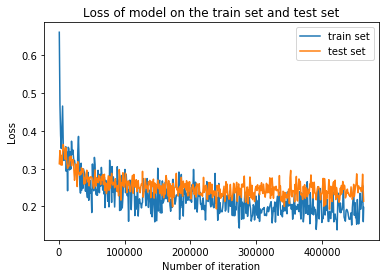

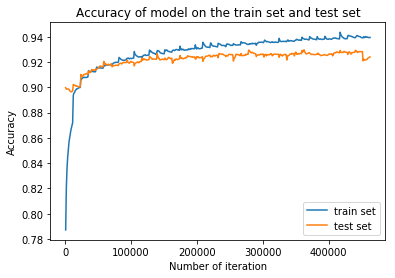

In [234]:
# plot loss of the model on the train set and test set
plt.plot(iter_list,train_loss_list,label='train set')
plt.plot(iter_list,test_loss_list,label='test set')
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel('Loss')
plt.title('Loss of model on the train set and test set')
plt.show()
# plot accuracy of the model on the train set and test set
plt.plot(iter_list,train_accu_list,label='train set')
plt.plot(iter_list,test_accu_list,label='test set')
plt.legend()
plt.xlabel("Number of iteration")
plt.ylabel('Accuracy')
plt.title('Accuracy of model on the train set and test set')
plt.show()